# Determine whether staff member at a salon has any effect on the average price for an appointment

*Now it's time to dive into ANOVAs in Python. A word to the wise, however - if you need advanced ANOVA capabilities, Python is not the tool for you.  Much better to flip over into R should you find yourself needing more than a down and dirty look via ANOVA. You will answer the same question and use the same data as you did in R, to give you a nice comparison of how the two programs function differently.*

*Where to start? Why, by importing packages, of course! You will need a whole variety of them, including pandas for basic data functions, numpy for any data transformations you may need to embark upon, scipy and stats for their statistics, and then a few specific things from them, including pairwise_tukeyhsd and MultiComparison* 

## Import Packages

In [5]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

## Import Data

In [3]:
salon = pd.read_csv('C:/Users/meredith.dodd/Documents/Data Science/105 Intermediate Statistics/Lesson 3/client_cancellations.csv')

In [4]:
salon.head()

,cancel date,cancel date month,code,service code,service desc,staff,booking date,booking date month,canceled by,days in adv,avg price
0,3/10/2018,March,KOOM01,SHCW,Women's hair cut,JJ,4/3/2018,April,JJ,24,88.44
1,3/27/2018,March,WIL*01,SHCW,Women's hair cut,JJ,3/29/2018,March,JJ,2,88.44
2,4/3/2018,April,BUDG02,SHCM,Men's hair cut,SINEAD,4/21/2018,April,BECKY,18,41.41
3,4/3/2018,April,HILJ01,CFC,Color full color,KELLY,4/3/2018,April,JJ,0,63.13
4,4/3/2018,April,STEM01,SHCW,Women's hair cut,BECKY,4/21/2018,April,JJ,18,67.84


## Data Wrangling

### Remove missing data

In [9]:
salon.dropna(inplace=True)

### Recoding your IV to numeric

*In order to run your tests for homogeneity of variance, weirdly enough, in Python your IV has got to be numeric.  So it's time to break out those recoding skills again. Go ahead and use value_counts to get a list of all the levels of your IV.*

In [20]:
salon.staff.value_counts()

JJ        68
BECKY     61
JOANNE    45
KELLY     44
SINEAD    19
TANYA      4
Name: staff, dtype: int64

*Then you can get to work recoding. The new recoded varaible will be called staffR, with the R at the end always standing for recode in my codebook.  Creating standards for yourself and your team about naming conventions can make your life a lot easier, and helps ensure that your data is interpretable by your fellows.*

*Then just apply that bad boy and ensure it worked as expected.*

In [21]:
def recode (series): 
    if series == "JJ":
        return 0
    if series == "BECKY": 
        return 1
    if series == "JOANNE": 
        return 2
    if series == "KELLY": 
        return 3
    if series == "SINEAD": 
        return 4
    if series == "TANYA": 
        return 5

salon['staffR'] = salon['staff'].apply(recode)

In [22]:
salon.head()

,cancel date,cancel date month,code,service code,service desc,staff,booking date,booking date month,canceled by,days in adv,avg price,avgPriceSQRT,staffR
0,3/10/2018,March,KOOM01,SHCW,Women's hair cut,JJ,4/3/2018,April,JJ,24,88.44,9.404254,0
1,3/27/2018,March,WIL*01,SHCW,Women's hair cut,JJ,3/29/2018,March,JJ,2,88.44,9.404254,0
2,4/3/2018,April,BUDG02,SHCM,Men's hair cut,SINEAD,4/21/2018,April,BECKY,18,41.41,6.435060,4
3,4/3/2018,April,HILJ01,CFC,Color full color,KELLY,4/3/2018,April,JJ,0,63.13,7.945439,3
4,4/3/2018,April,STEM01,SHCW,Women's hair cut,BECKY,4/21/2018,April,JJ,18,67.84,8.236504,1


## Test Assumptions

### Normality

*Next it's time to test assumptions.  You'll start with the assumption of normality, per usual.*

C:\Users\meredith.dodd\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


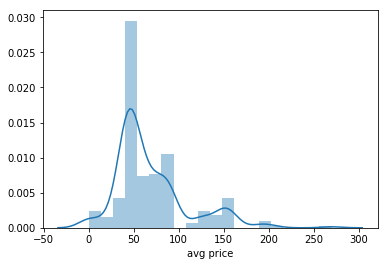

In [14]:
sns.distplot(salon['avg price'])

*It doesn't look terrible, but it is a little positively skewed, so try square rooting it using your friend numpy*

In [16]:
salon['avgPriceSQRT'] = np.sqrt(salon['avg price'])

*Then make sure that worked like you expected it to.*

In [17]:
salon.head()

,cancel date,cancel date month,code,service code,service desc,staff,booking date,booking date month,canceled by,days in adv,avg price,avgPriceSQRT
0,3/10/2018,March,KOOM01,SHCW,Women's hair cut,JJ,4/3/2018,April,JJ,24,88.44,9.404254
1,3/27/2018,March,WIL*01,SHCW,Women's hair cut,JJ,3/29/2018,March,JJ,2,88.44,9.404254
2,4/3/2018,April,BUDG02,SHCM,Men's hair cut,SINEAD,4/21/2018,April,BECKY,18,41.41,6.435060
3,4/3/2018,April,HILJ01,CFC,Color full color,KELLY,4/3/2018,April,JJ,0,63.13,7.945439
4,4/3/2018,April,STEM01,SHCW,Women's hair cut,BECKY,4/21/2018,April,JJ,18,67.84,8.236504


*And it did. Trust me, this is a good checks and balances, because sometimes you can have code run without errors that does not do what you think it does.  It is always good to check and have some visual confirmation.*

*Now take a look at your graph again to see if it transformed enough.*

C:\Users\meredith.dodd\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


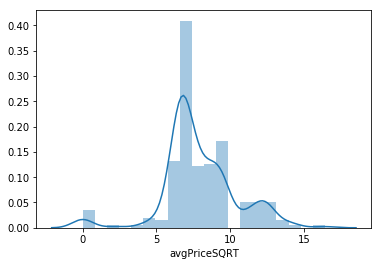

In [18]:
sns.distplot(salon['avgPriceSQRT'])

### Homogeneity of Variance

*Looking good! You'll take it. Now onto other fun things, like testing for homogeneity of variance. Again, you have the option in Python of doing either Bartlett's test or fligner's test.  Bartlett's is for when your data is normally distributed, naturally or artifically after transformation, and fligner's test is for when your data is non-parametric.  Just to demonstrate, you'll do both here, but the correct choice would be bartlett's, because your data does look approximately normal now.*

In [24]:
scipy.stats.bartlett(salon['avgPriceSQRT'], salon['staffR'])

BartlettResult(statistic=85.27913423862961, pvalue=2.59082839272849e-20)

*Just like in R, you find that this is signficant, which means you have violated the assumption of homogeneity of variance. Try the fligner test as well, just for funsies.*

In [25]:
scipy.stats.fligner(salon['avgPriceSQRT'], salon['staffR'])

FlignerResult(statistic=14.041888591291224, pvalue=0.00017878330489283094)

*And here's the same concept, but with the fligner test. Again, significant.*

### Sample size

*Again, the required sample size for ANOVAs is based on the number of independent variables.  You need at least 20 cases per independent variable, and in this case, you have 244, so you meet the assumption with flying colors*

### Independence

*Although there is no way to test for independence, you want to think through your analysis and ensure that the different levels of your independent variable are not related in any way.*

*Now you're on to your analysis! Unlike R, you will need to specify each comparison with all the levels, which makes this method a bit unwiedly.  If you need help remembering what levels you have, just go for .value_counts() again to put it at the forefront of your view. You will use the function stats.f_oneway.*

In [12]:
salon.staff.value_counts()

JJ        68
BECKY     61
JOANNE    45
KELLY     44
SINEAD    19
TANYA      4
Name: staff, dtype: int64

In [13]:
stats.f_oneway(salon['avg price'][salon['staff']=='JJ'],
               salon['avg price'][salon['staff']=='BECKY'],
               salon['avg price'][salon['staff']=='JOANNE'],
               salon['avg price'][salon['staff']=='KELLY'],
               salon['avg price'][salon['staff']=='SINEAD'], 
               salon['avg price'][salon['staff']=='TANYA'])

F_onewayResult(statistic=14.240380065681268, pvalue=3.553019748204266e-12)

*With that run, you find that there is a significant difference between staff members on how much their client is paying for services.  However, you don't know who is doing better than anyone else, so it's time to hit up the post hocs! In Python, the only post hoc that is easy to run is Tukey's, so you'll use that. It comes out of the MultiComparison library, and you'll use the postHoc.tukeyhsd function.  Fun fact - hsd stands for highly signficant difference!*

In [26]:
postHoc = MultiComparison(salon['avgPriceSQRT'], salon['staff'])
postHocResults = postHoc.tukeyhsd()
print(postHocResults)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
BECKY    JJ    1.0707  -0.1199  2.2612 False 
BECKY  JOANNE  2.8075   1.4809  4.1342  True 
BECKY  KELLY   0.9295  -0.4058  2.2648 False 
BECKY  SINEAD  0.2797  -1.4939  2.0534 False 
BECKY  TANYA  -0.1675  -3.6519  3.3169 False 
  JJ   JOANNE  1.7369   0.4396  3.0342  True 
  JJ   KELLY  -0.1412  -1.4473  1.165  False 
  JJ   SINEAD  -0.791  -2.5428  0.9609 False 
  JJ   TANYA  -1.2382  -4.7115  2.2352 False 
JOANNE KELLY   -1.878  -3.3093 -0.4468  True 
JOANNE SINEAD -2.5278  -4.3749 -0.6808  True 
JOANNE TANYA   -2.975  -6.4973  0.5473 False 
KELLY  SINEAD -0.6498   -2.503  1.2035 False 
KELLY  TANYA   -1.097  -4.6226  2.4286 False 
SINEAD TANYA  -0.4472  -4.1611  3.2666 False 
---------------------------------------------


*Once you print the results, you get a list of the means and how they differ. The meandiff column is the amount of difference between the means, and you are also given the confidence interval. Then, this output also conveniently tells you if you whether they are significant or not - if it is true, then you are rejecting the null hypothesis and there is a significant difference between that pair of staff members.  So, there is a difference between Joanne and Becky, JJ, Kelly, and Sinead.  Notice that this way, however, you don't get to make the call for yourself that Tanya was reallly close to being significant - in R you saw the p value was .057 - nearly there.  Here it uses a cutoff of .05 and you just need to take it at face value.*

*You may now be wondering where exactly the differences lie between the girls.  Is Joanne doing better, or worse than everyone else? The only way to tell is by examining the means, and you will want to examine the raw or original means, not the ones you have adjusted by taking the square root. Luckily, pandas has your back and swoops in to save the day with the groupby and .mean function.*

In [27]:
salon.groupby('staff').mean()

,days in adv,avg price,avgPriceSQRT,staffR
staff,,,,
BECKY,7.295082,51.064590,6.896776,1.0
JJ,5.029412,66.325588,7.967442,0.0
JOANNE,4.488889,108.042444,9.704312,2.0
KELLY,3.863636,66.137727,7.826262,3.0
SINEAD,7.368421,52.733684,7.176490,4.0
TANYA,2.000000,52.222500,6.729286,5.0


*So now you can see that, again, Joanne has had clients with a much higher average pay to her per visit than everyone else. Way to go Joanne! As a data scientist, you should be wondering what her secret is and trying to explore with the data you have.*